# Import Libraries

In [24]:
import math
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from math import sqrt
from pandas import concat
from matplotlib import pyplot
from keras.models import Sequential
from numpy import concatenate, asarray
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Stored 'fuel_data' (DataFrame)
Stored 'weather_data' (DataFrame)
Stored 'prec2022' (float64)
Stored 'temp2022' (float)


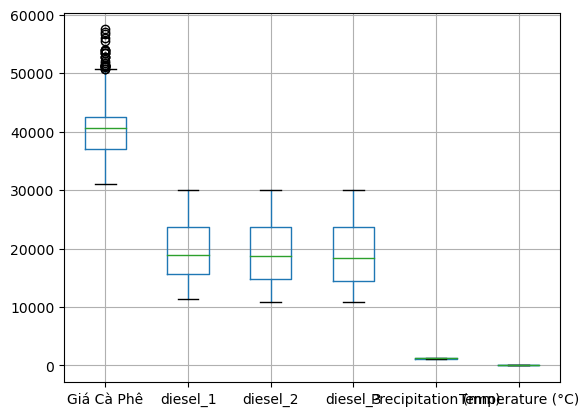

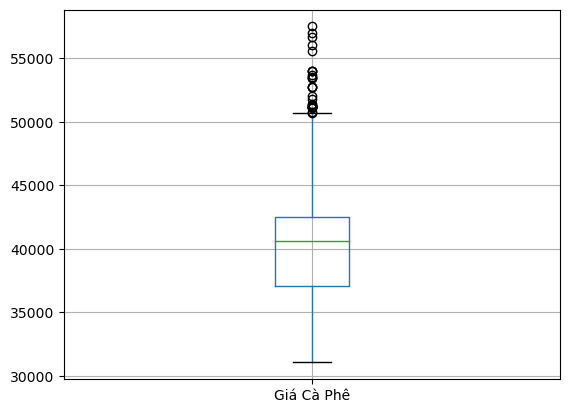

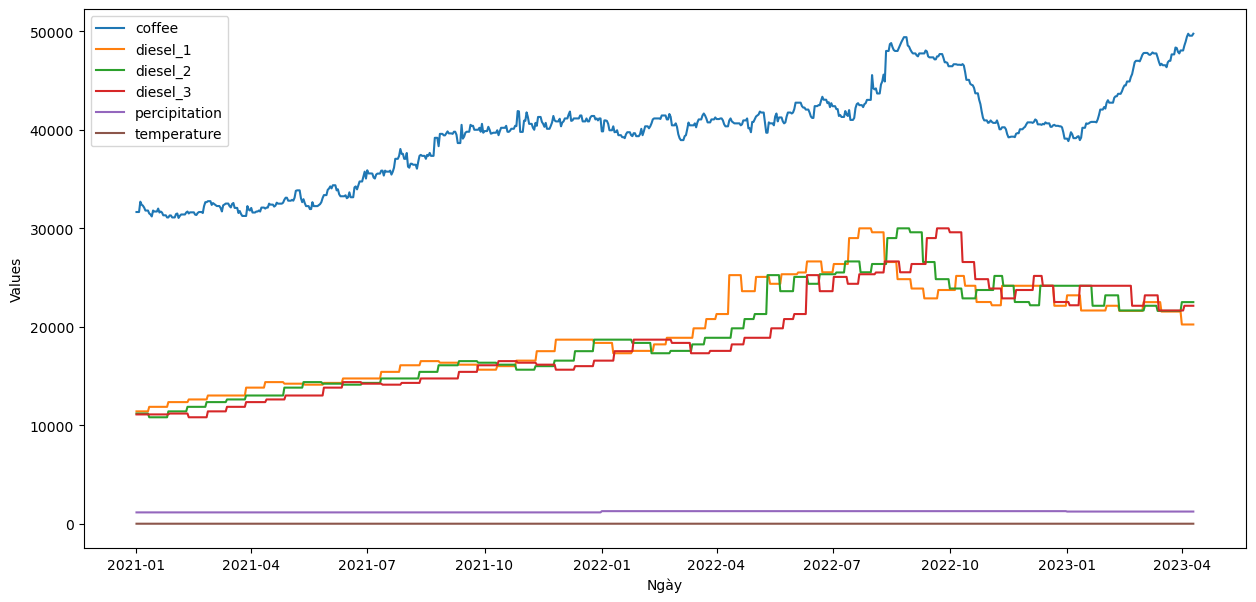

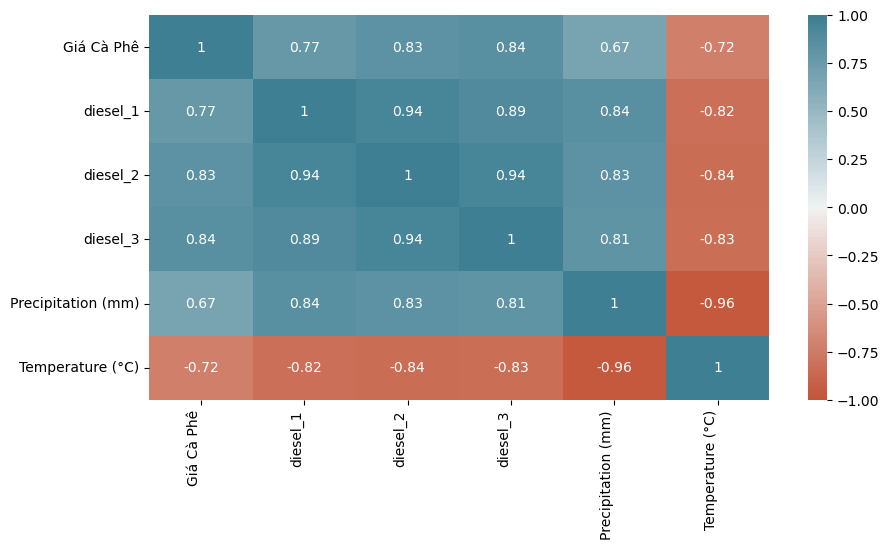

Stored 'data' (DataFrame)
Stored 'look_back' (int)
Stored 'predict_ahead' (int)


In [25]:
%run Data.ipynb

# ---------- Retrieve Data -----------

In [26]:
%store -r data
data

,Ngày,Giá Cà Phê,diesel_1,diesel_2,diesel_3,Precipitation (mm),Temperature (°C)
0,2021-01-01,31667.5,11430.0,11210.0,11120.0,1174.199994,24.937842
1,2021-01-02,31667.5,11430.0,11210.0,11120.0,1174.199994,24.937842
2,2021-01-03,31667.5,11430.0,11210.0,11120.0,1174.199994,24.937842
3,2021-01-04,32717.0,11430.0,11210.0,11120.0,1174.199994,24.937842
4,2021-01-05,32417.0,11430.0,11210.0,11120.0,1174.199994,24.937842
...,...,...,...,...,...,...,...
825,2023-04-06,49766.5,20250.0,22520.0,22150.0,1259.800013,24.170057
826,2023-04-07,49566.5,20250.0,22520.0,22150.0,1259.800013,24.170057
827,2023-04-08,49566.5,20250.0,22520.0,22150.0,1259.800013,24.170057
828,2023-04-09,49566.5,20250.0,22520.0,22150.0,1259.800013,24.170057


In [27]:
# take coffee price only
data.drop(data.columns[[-1, -2, -3, -4, -5]], axis=1, inplace=True)

In [28]:
data

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-02,31667.5
2,2021-01-03,31667.5
3,2021-01-04,32717.0
4,2021-01-05,32417.0
...,...,...
825,2023-04-06,49766.5
826,2023-04-07,49566.5
827,2023-04-08,49566.5
828,2023-04-09,49566.5


# --------- Normalization ----------

In [29]:
# drop date column
data.drop(data.columns[[0]], axis=1, inplace=True)

In [30]:
# set number of days
look_back = 60
predict_ahead = 30

# frame as supervised learning
reframed = series_to_supervised(data.values, look_back, predict_ahead)

In [31]:
# calculate total column to keep
data_column = len(data.columns)
keep_column = look_back * data_column
var_index = (look_back * data_column) + ((predict_ahead - 1) * data_column)

# drop unnecessary columns
reframed = reframed.drop(reframed.iloc[:, keep_column:var_index], axis = 1)
# index_drop = (data_column - 1 ) * -1
# reframed = reframed.drop(columns=reframed.columns[index_drop:], axis = 1)
# dataset = reframed

In [32]:
reframed

,var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t+29)
60,31667.5,31667.5,31667.5,32717.0,32417.0,32317.0,32117.0,31817.0,31817.0,31817.0,...,31667.0,31567.0,32267.0,32667.0,32667.00,32767.00,32767.00,32767.00,32388.75,31817.0
61,31667.5,31667.5,32717.0,32417.0,32317.0,32117.0,31817.0,31817.0,31817.0,31517.0,...,31567.0,32267.0,32667.0,32667.0,32767.00,32767.00,32767.00,32388.75,32575.00,32081.5
62,31667.5,32717.0,32417.0,32317.0,32117.0,31817.0,31817.0,31817.0,31517.0,31417.0,...,32267.0,32667.0,32667.0,32767.0,32767.00,32767.00,32388.75,32575.00,32475.00,31617.0
63,32717.0,32417.0,32317.0,32117.0,31817.0,31817.0,31817.0,31517.0,31417.0,31217.0,...,32667.0,32667.0,32767.0,32767.0,32767.00,32388.75,32575.00,32475.00,32375.00,31617.0
64,32417.0,32317.0,32117.0,31817.0,31817.0,31817.0,31517.0,31417.0,31217.0,31817.0,...,32667.0,32767.0,32767.0,32767.0,32388.75,32575.00,32475.00,32375.00,32275.00,31617.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,39166.5,39166.5,39316.5,39366.5,38966.5,39216.5,40216.5,40216.5,40216.5,40666.5,...,46966.5,47266.5,47616.5,47800.0,47816.50,47816.50,47816.50,47666.50,47616.50,49766.5
796,39166.5,39316.5,39366.5,38966.5,39216.5,40216.5,40216.5,40216.5,40666.5,40616.5,...,47266.5,47616.5,47800.0,47816.5,47816.50,47816.50,47666.50,47616.50,47716.50,49566.5
797,39316.5,39366.5,38966.5,39216.5,40216.5,40216.5,40216.5,40666.5,40616.5,40666.5,...,47616.5,47800.0,47816.5,47816.5,47816.50,47666.50,47616.50,47716.50,47866.50,49566.5
798,39366.5,38966.5,39216.5,40216.5,40216.5,40216.5,40666.5,40616.5,40666.5,40766.5,...,47800.0,47816.5,47816.5,47816.5,47666.50,47616.50,47716.50,47866.50,47766.50,49566.5


In [33]:
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(reframed)
scaled.shape

(740, 61)

# ---------- Split data ----------

In [34]:
dataset = scaled

# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

592 148


In [35]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(592, 1, 60) (592,) (148, 1, 60) (148,)


# ---------- Train Model ----------

In [ ]:
# design network
model = Sequential()
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=32, 
                    validation_data=(test_X, test_y), verbose=False, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# ---------- Testing & Results Analysis ----------

In [ ]:
# calculate metrics
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = sklearn.metrics.mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

def print_metrics(test, pre_test):
    
    testScore = np.sqrt(mean_squared_error(test,pre_test))
    print('RMSE: %.2f (đồng)' % (testScore))
    
    testScore = sklearn.metrics.mean_absolute_error(test, pre_test)
    print('\nMAE: %.2f (đồng)' % (testScore))
                            
    testScore = sklearn.metrics.mean_absolute_percentage_error(test, pre_test)
    print('\nMAPE: %.2f' % (testScore))
    
    testScore = mean_absolute_scaled_error(test, pre_test, test)
    print('\nMASE: %.2f' % (testScore))

In [ ]:
# make a prediction
test_pred = (model.predict(test_X))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [ ]:
test_X

In [ ]:
# invert scaling for forecast
inv_test_pred = concatenate((test_pred, test_X), axis=1)
inv_test_pred = scaler.inverse_transform(inv_test_pred)
inv_test_pred = inv_test_pred[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
# print results
print_metrics(inv_y, inv_test_pred)

# ---------- Predicting ----------

In [ ]:
# take the last look back days
df = data.tail(look_back)
# normalize features
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [ ]:
# convert rows to columns
dataset = df.T

# convert
# dataset = df.to_numpy() 

# reshape
X = dataset.reshape((dataset.shape[0], 1, dataset.shape[1]))

In [ ]:
# predict
prediction = model.predict(X)

In [ ]:
# replace 1st value by prediction result in order to invert scale
df[0] = prediction

# invert scaling
inv_prediction = scaler.inverse_transform(df)
final_result = inv_prediction[0]

In [ ]:
final_result[0]